In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# import numpy.random as r
from sklearn.metrics import accuracy_score

## Data for testing

In [7]:
digits = load_digits()
print(digits.data.shape)
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
y = digits.target

(1797, 64)


In [30]:
class Network(object):
    
    def __init__(self, x, y, nn_structure, test_size):
        """initiate NN with x and y, nn_structure
        """
        self.X = x
        self.y = y
        self.nn_structure=nn_structure
        #split test and trainig data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
        #vectorize y
        self.y_v_train=self.convert_y_to_vect(self.y_train)
        self.y_v_test=self.convert_y_to_vect(self.y_test)
        self.y_pred=None

        self.alpha=None
        self.lamb=None
        self.iter_num=None
        
        self.avg_cost_func=[]
        self.W=None
        self.b=None
     
    def convert_y_to_vect(self, y):
        y_vect = np.zeros((len(y), 10))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    def f(self, x):
        return 1 / (1 + np.exp(-x))
        
    def f_deriv(self,x):
        return self.f(x) * (1 - self.f(x))
    
    def setup_and_init_weights(self):
        W = {}
        b = {}
        for l in range(1, len(self.nn_structure)):
            W[l] = np.random.random_sample((self.nn_structure[l], self.nn_structure[l-1]))
            b[l] = np.random.random_sample((self.nn_structure[l],))
        return W, b
    
    def init_tri_values(self):
        tri_W = {}
        tri_b = {}
        for l in range(1, len(self.nn_structure)):
            tri_W[l] = np.zeros((self.nn_structure[l], self.nn_structure[l-1]))
            tri_b[l] = np.zeros((self.nn_structure[l],))
        return tri_W, tri_b
    
    def feed_forward(self, x, W, b):
        h = {1: x}
        z = {}
        for l in range(1, len(W) + 1):
            # if it is the first layer, then the input into the weights is x, otherwise, 
            # it is the output from the last layer
            if l == 1:
                node_in = x
            else:
                node_in = h[l]
            z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
            h[l+1] = self.f(z[l+1]) # h^(l) = f(z^(l)) 
        return h, z
    
    def calculate_out_layer_delta(self, y, h_out, z_out):
        # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
        return -(y-h_out) * self.f_deriv(z_out)
    
    def calculate_hidden_delta(self, delta_plus_1, w_l, z_l):
        # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
        return np.dot(np.transpose(w_l), delta_plus_1) * self.f_deriv(z_l)
    
    def train_nn(self):
        raise NotImplementedError

    def plot_avg_cost_func(self):
        if len(self.avg_cost_func)==0:
            print('Please train model before visalizing average cost')
            return
        plt.plot(self.avg_cost_func)
        plt.ylabel('Average J')
        plt.xlabel('Iteration number')
        plt.show()
        
    def predict_y(self):
        m = self.X_test.shape[0]
        y = np.zeros((m,))
        for i in range(m):
            h, z = self.feed_forward(self.X_test[i, :], self.W, self.b)
            y[i] = np.argmax(h[len(self.nn_structure)])
        self.y_pred=y
        
    def get_test_accuracy(self):
        self.predict_y()
        return accuracy_score(self.y_test, self.y_pred)*100

In [31]:
class NetworkSimple(Network):
    def __init__(self,  x, y, nn_structure, test_size):
        Network.__init__(self,  x, y, nn_structure, test_size)
        
    def train_nn(self, iter_num=3000, alpha=0.25, lamb=0.000):
        self.lamb=lamb
        self.alpha=alpha
        self.iter_num=iter_num
        
        W, b = self.setup_and_init_weights()
        cnt = 0
        m = len(self.y_v_train)
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = self.init_tri_values()
            avg_cost = 0
            for i in range(len(self.y_v_train)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, z = self.feed_forward( self.X_train[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(self.nn_structure), 0, -1):
                    if l == len(self.nn_structure):
                        delta[l] = self.calculate_out_layer_delta(self.y_v_train[i,:], h[l], z[l])
                        avg_cost += np.linalg.norm((self.y_v_train[i,:]-h[l]))
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(self.nn_structure) - 1, 0, -1):
                W[l] += -alpha * (1.0/m * tri_W[l]+lamb * W[l])
                b[l] += -alpha * (1.0/m * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/m * avg_cost
            self.avg_cost_func.append(avg_cost)
            cnt += 1
        self.W=W
        self.b=b

In [41]:
class NetworkMBGD(Network):
    def __init__(self,  x, y, nn_structure, test_size):
        Network.__init__(self,  x, y, nn_structure, test_size)
        
    def get_mini_batches(self, X, y, batch_size):
        random_idxs = np.random.choice(len(y), len(y), replace=False)
        X_shuffled = self.X_train[random_idxs,:]
        y_shuffled = self.y_v_train[random_idxs]
        mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                       i in range(0, len(self.y_v_train), batch_size)]
        return mini_batches
    
    def train_nn(self, iter_num=3000, bs=100, alpha=0.25, lamb=0.000):
        self.lamb=lamb
        self.alpha=alpha
        self.iter_num=iter_num
        
        W, b = self.setup_and_init_weights()
        cnt = 0
        m = len(self.y_v_train)
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = self.init_tri_values()
            avg_cost = 0
            mini_batches = self.get_mini_batches(self.X_train, self.y_v_train, bs)
            for mb in mini_batches:
                X_mb = mb[0]
                y_mb = mb[1]
                # pdb.set_trace()
                for i in range(len(y_mb)):
                    delta = {}
                    # perform the feed forward pass and return the stored h and z values, 
                    # to be used in the gradient descent step
                    h, z = self.feed_forward(X_mb[i, :], W, b)
                    # loop from nl-1 to 1 backpropagating the errors
                    for l in range(len(self.nn_structure), 0, -1):
                        if l == len(self.nn_structure):
                            delta[l] = self.calculate_out_layer_delta(y_mb[i,:], h[l], z[l])
                            avg_cost += np.linalg.norm((y_mb[i,:]-h[l]))
                        else:
                            if l > 1:
                                delta[l] = self.calculate_hidden_delta(delta[l+1], W[l], z[l])
                            # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                            tri_W[l] += np.dot(delta[l+1][:,np.newaxis], 
                                              np.transpose(h[l][:,np.newaxis])) 
                            # trib^(l) = trib^(l) + delta^(l+1)
                            tri_b[l] += delta[l+1]
                # perform the gradient descent step for the weights in each layer
                for l in range(len(self.nn_structure) - 1, 0, -1):
                    W[l] += -alpha * (1.0/bs * tri_W[l] + lamb * W[l])
                    b[l] += -alpha * (1.0/bs * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/m * avg_cost
            self.avg_cost_func.append(avg_cost)
            cnt += 1
        self.W=W
        self.b=b

In [49]:
class NetworkSGD(Network):
    def __init__(self,  x, y, nn_structure, test_size):
        Network.__init__(self,  x, y, nn_structure, test_size)
        
    def train_nn(self, iter_num=3000, alpha=0.25, lamb=0.000):
        self.lamb=lamb
        self.alpha=alpha
        self.iter_num=iter_num
        
        W, b = self.setup_and_init_weights()
        cnt = 0
        m = len(self.y_v_train)
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = self.init_tri_values()
            avg_cost = 0
            for i in range(len(self.y_v_train)):
                delta = {}
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                h, z = self.feed_forward( self.X_train[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(self.nn_structure), 0, -1):
                    if l == len(self.nn_structure):
                        delta[l] = self.calculate_out_layer_delta(self.y_v_train[i,:], h[l], z[l])
                        avg_cost += np.linalg.norm((self.y_v_train[i,:]-h[l]))
                    else:
                        if l > 1:
                            delta[l] = self.calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
                # perform the gradient descent step for the weights in each layer. Only change comaperd to simple NN
                for l in range(len(self.nn_structure) - 1, 0, -1):
                    W[l] += -alpha * (1.0/m * tri_W[l]+lamb * W[l])
                    b[l] += -alpha * (1.0/m * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/m * avg_cost
            self.avg_cost_func.append(avg_cost)
            cnt += 1
        self.W=W
        self.b=b

## Test classes

In [42]:
nn_MBGD=NetworkMBGD(X, y,[64, 30, 10], 0.4)

In [43]:
nn_MBGD.train_nn()
nn_MBGD.get_test_accuracy()

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


96.522948539638392

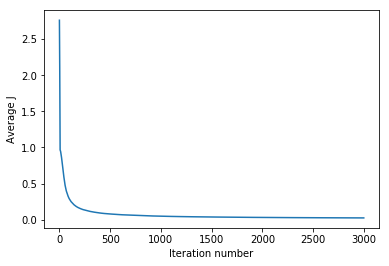

In [44]:
nn_MBGD.plot_avg_cost_func()

In [45]:
nn_simple=NetworkSimple(X, y,[64, 30, 10], 0.4)

In [46]:
nn_simple.train_nn()

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


In [47]:
nn_simple.get_test_accuracy()

87.204450625869271

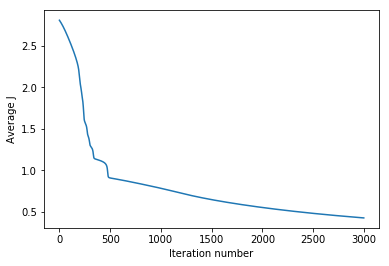

In [48]:
nn_simple.plot_avg_cost_func()

In [50]:
nn_SGD=NetworkSGD(X, y,[64, 30, 10], 0.4)
nn_SGD.train_nn()
nn_SGD.get_test_accuracy()

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


78.164116828929068

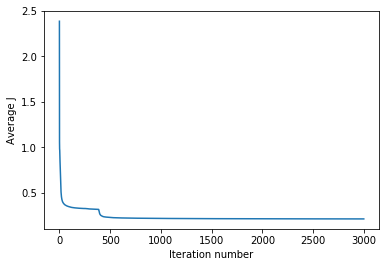

In [51]:
nn_SGD.plot_avg_cost_func()

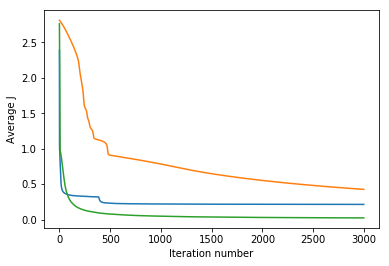

In [52]:
plt.plot(nn_SGD.avg_cost_func)
plt.plot(nn_simple.avg_cost_func)
plt.plot(nn_MBGD.avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()